# INFILTRATION model - Main notebook

Hello, and welcome back.


The DEF code is a final, cleaned and commented version.
This version implements an hourly ET0 calculated with hourly FAO-56 Penman-Monteith and a SWB model that is properly corrected for hourly calculation of the evapotranspiration.
Kc curves are also externally defined in a module of their own.

In [1]:
# libraries
import os
import sys
import json
import logging

sys.path.append('../')

# custom modules
from Modules.lib_io import *
from Modules.lib_pso import *
from Modules.lib_CROP import *
from Modules.lib_EPOT import *
from Modules.lib_SOIL import *
from Modules.lib_plot import *
from Modules.lib_generic import *
from Modules.lib_settings import *
from Modules.lib_analysis import *
from Modules.lib_models_components import *
from Modules.SWB1_REPIETRA import SWB1

# Inputs

## Configuration file

In [2]:
# Parse data settings
file_settings          = 'configuration.json'
parsed_settings        = get_data_settings(file_settings)
# parsed_settings      = parse_data_settings(data_settings)

# Function to recursively assign variables from nested dictionaries
def assign_variables(config_dict, prefix=''):
    for key, value in config_dict.items():
        if isinstance(value, dict):
            # For nested dictionaries, add the current key to the prefix and recursively call the function
            assign_variables(value, prefix=prefix + key + '_')
        else:
            # Assign the value to a global variable with the constructed name
            globals()[prefix + key] = value

# Call the function with the parsed configuration
# assign_variables(parsed_settings)

# Retrieve variables from the 'options' dictionary
verbose                = True if parsed_settings['options']['verbose']=='True' else False
units                  = parsed_settings['options']['units']
opt_veg                = parsed_settings['options']['opt_veg']
opt_calib              = parsed_settings['options']['opt_calib']
opt_cost               = parsed_settings['options']['opt_cost']
opt_field              = parsed_settings['options']['opt_field']
start_date             = parsed_settings['options']['start_date']
end_date               = parsed_settings['options']['end_date']
format_date            = parsed_settings['options']['format_date']
add_description        = parsed_settings['options']['add_description']

# Retrieve variables from the 'paths' dictionary
root                   = parsed_settings['paths']['root']
file_sm15              = os.path.join(root, parsed_settings['paths']['data_input']['file_sm15'])
file_sm35              = os.path.join(root, parsed_settings['paths']['data_input']['file_sm35'])

# Retrieve variables from the 'paths' -> 'data_output' dictionary
filename_template      = f"{parsed_settings['paths']['data_output']['filename_template']}"
folder_plot            = os.path.join(root, parsed_settings['paths']['data_output']['folder_plot'])
filename_params        = parsed_settings['paths']['data_output']['filename_params']
filename_table_machine = parsed_settings['paths']['data_output']['filename_table_machine']
filename_table_params  = parsed_settings['paths']['data_output']['filename_table_params']
filename_triple        = parsed_settings['paths']['data_output']['filename_triple']
filename_scatter       = parsed_settings['paths']['data_output']['filename_scatter']
extension_plot         = parsed_settings['paths']['data_output']['extension_plot']
opt_save               = True if parsed_settings['paths']['data_output']['opt_save']=='True' else False

# Retrieve variables from the 'input' dictionary
col_date               = parsed_settings['input']['col_date']
col_rain               = parsed_settings['input']['col_rain']
col_temp               = parsed_settings['input']['col_temp']
col_sm15               = parsed_settings['input']['col_sm15']
col_sm35               = parsed_settings['input']['col_sm35']
time_freq_in           = parsed_settings['input']['time_freq_in']
time_freq_out          = parsed_settings['input']['time_freq_out']
time_form              = parsed_settings['input']['time_form']

# Retrieve variables from the 'field_params' dictionary
epot                   = parsed_settings['field_params']['epot']
lat_deg                = parsed_settings['field_params']['lat_deg']
saturation             = parsed_settings['field_params']['saturation']
field_capacity         = parsed_settings['field_params']['field_capacity']
wilting_point          = parsed_settings['field_params']['wilting_point']
depth_single           = parsed_settings['field_params']['depth_single']

# Retrieve variables from the 'calibration' dictionary
PAR_dict               = parsed_settings['calibration']['PAR']
bounds_low             = parsed_settings['calibration']['bounds']['low']
bounds_up              = parsed_settings['calibration']['bounds']['up']
nrun                   = parsed_settings['calibration']['run_params']['nrun']
n_particles            = parsed_settings['calibration']['run_params']['n_particles']
n_step                 = parsed_settings['calibration']['run_params']['n_step']
optim                  = parsed_settings['calibration']['run_params']['optim']
norma                  = parsed_settings['calibration']['run_params']['norma']
verbose_calib          = True if parsed_settings['calibration']['run_params']['verbose_calib']=='True' else False
automate               = True if parsed_settings['automate']['flag']=='True' else False

In [3]:
# Dataframes
# ----------
# Meteo and situ data
df_sm15                  = pd.read_excel(file_sm15).rename(columns={
    col_date:'Date', col_rain:'Rain[mm]', col_temp:"Temp[°C]", col_sm15:"SM15[m3m-3]"
}).set_index('Date')
df_sm35                  = pd.read_excel(file_sm35).rename(columns={
    col_date:'Date', col_rain:'Rain[mm]', col_temp:"Temp[°C]", col_sm35:"SM35[m3m-3]"
}).set_index('Date')
df_meteo_sm = pd.merge(df_sm15, df_sm35, on=['Date', 'Rain[mm]', 'Temp[°C]'], how='inner')
df_meteo_sm['Rain[mm]'] = df_meteo_sm['Rain[mm]'].apply(lambda x : x if x>0 and not np.isnan(x) else 0)
df_sm = df_meteo_sm.drop(columns=['Rain[mm]', 'Temp[°C]']).dropna()

In [4]:
# ETO calculation

dates     = pd.to_datetime(df_meteo_sm.resample('d').mean().index)
temp_mean = df_meteo_sm.resample('d').mean()['Temp[°C]'].values
temp_min  = df_meteo_sm.resample('d').min()['Temp[°C]'].values
temp_max  = df_meteo_sm.resample('d').max()['Temp[°C]'].values
eto_list  = np.array([hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i]) for i in range(len(dates))])
eto_list[eto_list < 0] = 0
eto = timeseries(dates, eto_list)
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'PET'}).set_index('Date')
eto_df_hargre = eto_df.resample(time_freq_in).asfreq().interpolate()

dates = pd.to_datetime(df_meteo_sm.index)
temp_mean = df_meteo_sm['Temp[°C]'].values
eto_list = np.array([hamon(temp_mean[i], dates[i].day, lat_deg, par=1) for i in range(len(dates))])
eto_list[eto_list < 0] = 0
eto = timeseries(dates, eto_list)
eto_df_hamon = pd.DataFrame(eto).rename(columns={0:'Date',1:'PET'}).set_index('Date')
if epot=='hargre': eto_df=eto_df_hargre.copy()
elif epot=='hamon': eto_df=eto_df_hamon.copy()
else: raise KeyError('Provide "hargre" or "hamon" as options for epot.')

print('Check if Hargreaves and Hamon methods give different results...')
eto_df_complete = pd.merge(eto_df_hargre, eto_df_hamon, on='Date').dropna()
R_eto = np.corrcoef(eto_df_complete.PET_x.values, eto_df_complete.PET_y.values)[0][1]
print('Correlation coefficient Hargreaves VS Hamon: ', R_eto)

Check if Hargreaves and Hamon methods give different results...
Correlation coefficient Hargreaves VS Hamon:  0.7846286671167381


In [5]:
print('Check input dataset for soil water balance...\n')
input_swb = pd.merge(df_meteo_sm, eto_df, left_index=True, right_index=True)
print(input_swb.info())

Check input dataset for soil water balance...

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30285 entries, 2020-08-06 15:00:00 to 2024-01-20 11:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rain[mm]     30285 non-null  float64
 1   Temp[°C]     30285 non-null  float64
 2   SM15[m3m-3]  28178 non-null  float64
 3   SM35[m3m-3]  28178 non-null  float64
 4   PET          30285 non-null  float64
dtypes: float64(5)
memory usage: 1.4 MB
None


Plot input data for soil water balance...



<Axes: xlabel='Date'>

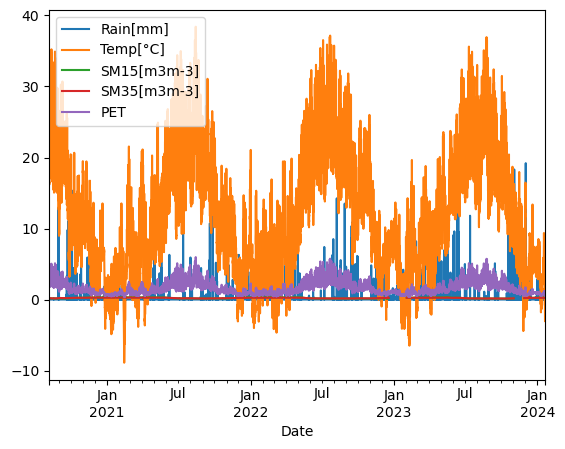

In [6]:
print('Plot input data for soil water balance...\n')
input_swb.plot()

In [7]:
# Create masks for study periods
# Create masks for gaps in soil moisture 

if start_date=='start' and end_date=='end':
    start_date=input_swb.index.values[0]
    end_date=input_swb.index.values[-1]
else:
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
mask_t      = (input_swb.index > start_date) & (input_swb.index <= end_date)
mask_t_sm   = (df_sm.index > start_date) & (df_sm.index <= end_date)
mask_gap_sm = np.isin(input_swb[mask_t].index, df_sm[mask_t_sm].index)



# ----------------------------------------------------------
# ----------------------------------------------------------
# INPUTS

# Saturation, field capacity, wilting point
WW_sat  = saturation
WW_fc   = field_capacity
WW_w    = wilting_point

# ----------------------------------------------------------
# Crop parameters
rho_st  = 0.7

# ----------------------------------------------------------
# Precipitation
P       = input_swb[mask_t]['Rain[mm]'].values # [mm]

# ----------------------------------------------------------
# Evapotranspiration
# EPOT can be used from data or model (Hargreaves) with no particular preference (R = 0.93, bias = 0.15)
# EPOT    = input_swb.loc[t][f'PET_mean[mm/day]_{opt_field}'].values # [mm/day]
TEMP    = input_swb[mask_t]['Temp[°C]'].values; TEMP[TEMP<0]=0
EPOT    = input_swb[mask_t]['PET'].values # [mm/day]

# ----------------------------------------------------------
# Soil moisture
# soil moisture values as benchmark
sm15    = df_sm[mask_t_sm]['SM15[m3m-3]'].values
sm35    = df_sm[mask_t_sm]['SM35[m3m-3]'].values

sm15_ext  = input_swb[mask_t]['SM15[m3m-3]'].values
sm35_ext  = input_swb[mask_t]['SM35[m3m-3]'].values
depth     = depth_single

# ----------------------------------------------------------
# Dates
t       = input_swb[mask_t].index
t_sm    = df_sm[mask_t_sm].index

# List of inputs for calibrating the model
inputs  = [t, mask_gap_sm, P, EPOT, sm35, rho_st]

In [8]:
print('List the days in which there are gaps in soil moisture...\n')
t_gap = input_swb[mask_t][~mask_gap_sm].resample('D').asfreq().index
print(t_gap)
print('\nMissing days in period: ', len(t_gap))

List the days in which there are gaps in soil moisture...

DatetimeIndex(['2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-17', '2022-12-18', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30', '2022-12-31', '2023-01-01',
               '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09',
               '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13',
               '2023-01-14', '2023-01-15', '2023-01-16', '2023-01-17',
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-21',
               '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25',
               '2023-01-26', '2023-01-27', '2023-01-28', '2023-01-29',
               '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02'],
              dty

Plot the soil moisture timeseries

Plot soil moisture timeseries...



<Axes: xlabel='Date'>

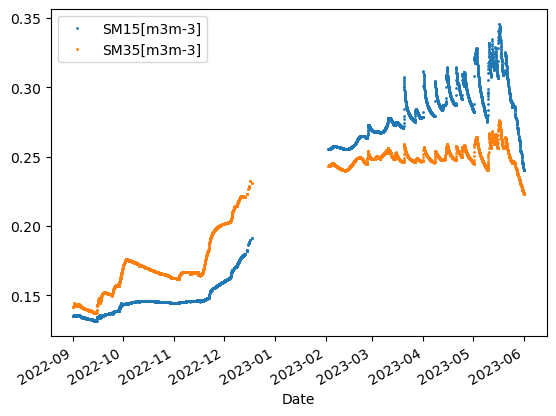

In [9]:
print('Plot soil moisture timeseries...\n')
df_sm[mask_t_sm].plot(marker='o',ls='', ms=1)

# Calibration SWB+WCM

In [10]:
# Calibration SWB
# ----------------------------------------------------------------------------

# PARameters to calibrate
PAR = list(PAR_dict.values())
PAR_str = list(PAR_dict.keys())
bounds = ( np.array(bounds_low, dtype=float), np.array(bounds_up, dtype=float) )

PAR_dict_default = {
    label:[PAR_dict[label]] for label in PAR_dict
}

args = {
    'PAR_str': PAR_str,
    'inputs': inputs,
    'user_in': '',
}

model = SWB1(**args)

In [11]:
print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

from pyswarms.backend.handlers import OptionsHandler

# if opt_params=='y':
params = []
start = time.time()
for i in range(int(nrun)):
    print('Run number ', i+1)

    optim='global'
    options = {'w': 0.6, 'c1': 2.05, 'c2': 2.05}
    oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}
        # oh_strategy: exp_decay, lin_variation, random, nonlin_mod
    bh_strategy = 'reflective' # nearest, random, shrink, reflective, intermediate
    vh_strategy = 'adjust' # unmodified, adjust, invert, zero 
    # init_pos = np.array([PAR]*int(n_particles))
    optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                        dimensions=len(PAR),
                                        options=options,
                                        bounds=bounds,
                                        oh_strategy=oh_strategy,
                                        # bh_strategy=bh_strategy,
                                        # vh_strategy=vh_strategy,
                                        # init_pos=init_pos,
                                       )
    cost, PARn = optimizer.optimize(model.pso_calib_irri, iters=n_step, n_processes=None, verbose=verbose_calib)
    params.append(PARn)
    end = time.time()

    if i==0:
        time_sec = round(end-start, 2)
        time_min =  round((end-start)/60, 2)
        print(time_min, ' min for last run,', time_min*nrun , ' min estimated')
    print('Time left: ', round((start+time_sec*nrun-end)/60,2), 'min')

timestr = time.strftime("%Y-%m-%d_%H%M%S"); print('Timestring: ', timestr)
parsed_settings['options']['timestr'] = timestr

print('\nTiming: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

filename = substitute_keywords(filename_template, **parsed_settings['options'])

print('\n#--------------------------------------------------',f'\n\nFilename = {filename}*')

2024-02-20 17:03:00,124 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'w': 0.6, 'c1': 2.05, 'c2': 2.05}


Starting calibration...
#-------------------------------------------------------------

Run number  1


pyswarms.single.global_best: 100%|███████████████████████████████████|200/200, best_cost=0.024
2024-02-20 17:04:49,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.024011672054332744, best pos: [5.44421647e+00 1.14195652e-01 2.11686231e+01 6.64815978e+01
 1.99502521e+03 3.59782864e-01 5.34596678e-02]


1.83  min for last run, 1.83  min estimated
Time left:  0.0 min
Timestring:  2024-02-20_170449

Timing:  1.83  min for 1 run, 1.83 min total

#-------------------------------------------------- 

Filename = repietra_2024-02-20_170449_{add_description}*


In [19]:
parsed_settings['options']

{'verbose': 'True',
 'units': 'lin',
 'opt_veg': 'NDVI',
 'opt_calib': '1',
 'opt_cost': 'KGE',
 'opt_field': 'repietra',
 'start_date': '2022-09-01',
 'end_date': '2023-06-01',
 'format_date': '%Y-%m-%d',
 'timestr': '2024-02-20_170449'}

# Parameters' study

In [12]:
PAR_dict, rowLabels = parameters_analysis(params, PAR_dict_default, PAR, PAR_str, bounds, '', automate, nbins=10, opt_fit=False, root=folder_plot+filename)

if automate: opt_save=True
else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False

if opt_save:
    path_params = folder_plot+filename+filename_params+'.json'
    with open(path_params, 'w') as file: json.dump(PAR_dict, file)
    file.close()

# Model output - plots sim VS obs for SM, sigma0

In [13]:
# Model validation and output

PARn = [PAR_dict[label][3] for label in PAR_dict if label in PAR_str]
WW1,PERC1,IE,ET1,KGE = model.model(PAR=PARn, **args)

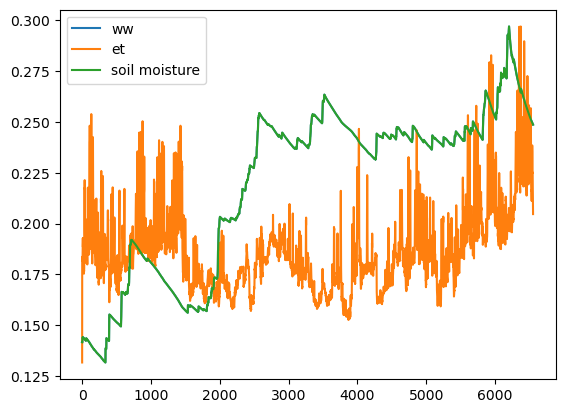

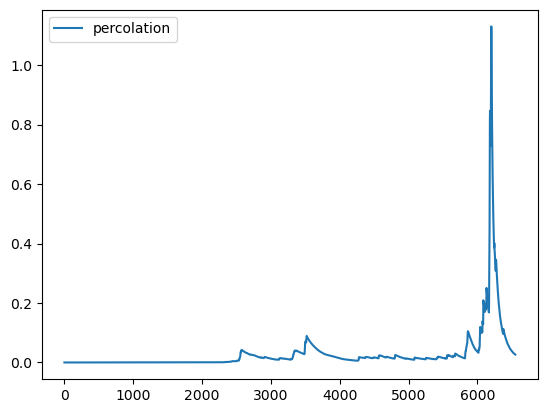

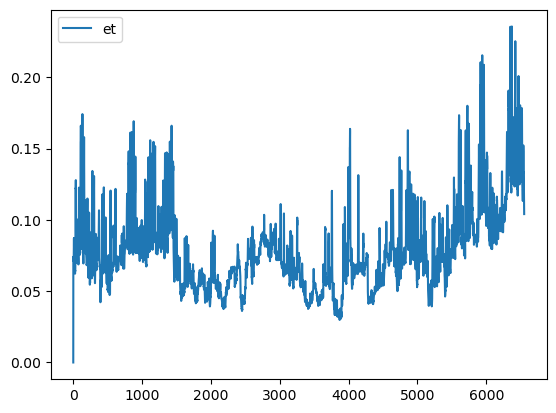

In [14]:
plt.plot(WW1, label='ww')
plt.plot(norm_fit(ET1, min(WW1), max(WW1)), label='et')
plt.legend()

for var, label in zip([WW1,PERC1,ET1],['soil moisture', 'percolation', 'et']):
    plt.plot(var, label=label)
    plt.legend()
    plt.show()

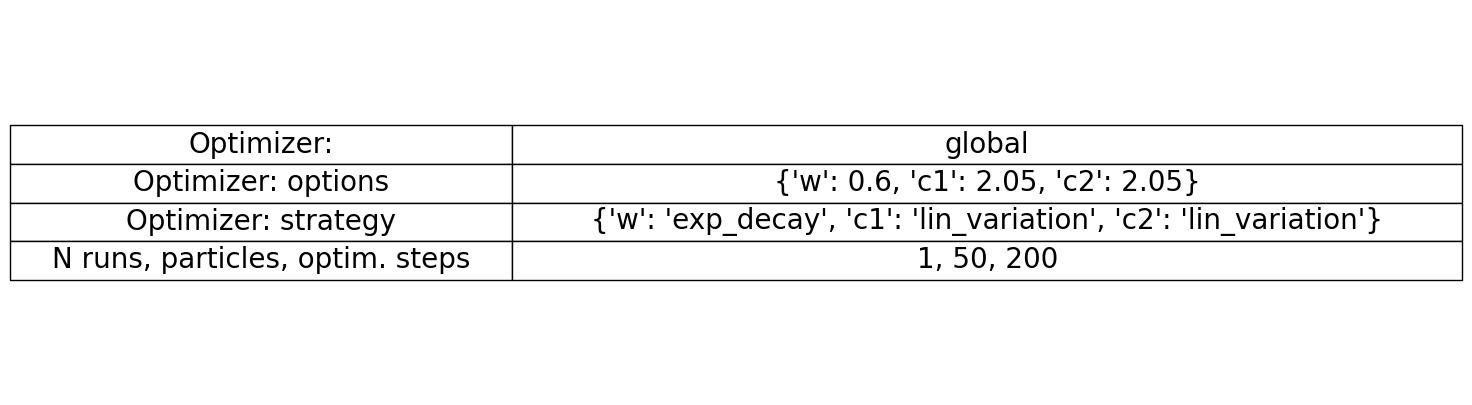

In [15]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if time_freq_in=='d' else 'hourly'
calib = 'sigma0' if opt_calib=='1' else 'sigma0+sm'
cellText = [
    # ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(len(params))+', '+str(n_particles)+', '+str(n_step)],
    # ['Time frequency', timing],
    # ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(folder_plot+filename+filename_table_machine+extension_plot, dpi=100)
plt.show()

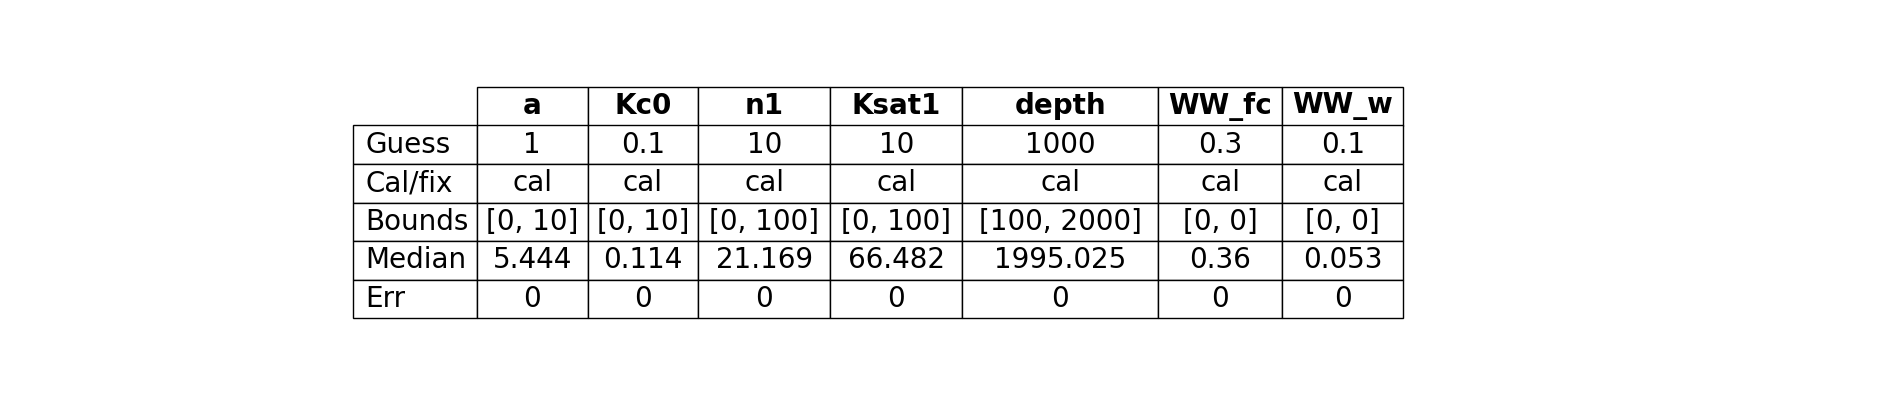

In [16]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

cellText = [
    [
        significant_figures_str(PAR_dict[label][3],PAR_dict[label][i])[1]
        if (PAR_dict[label][2]=='cal') and (type(PAR_dict[label][i])==float)
        else PAR_dict[label][i]
        for label in PAR_dict
    ] 
    for i in range(0,len(rowLabels))]

# colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
# rowLabels = [ 'Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']
colLabels = [ f'{label}' for label in PAR_dict ]

#---------------------------------
table = ax.table(cellText=cellText,
                 cellLoc='center', loc='center',
                 colLabels=colLabels,
                 rowLabels=rowLabels,
                 )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(folder_plot+filename+filename_table_params+extension_plot, dpi=300)
plt.show()

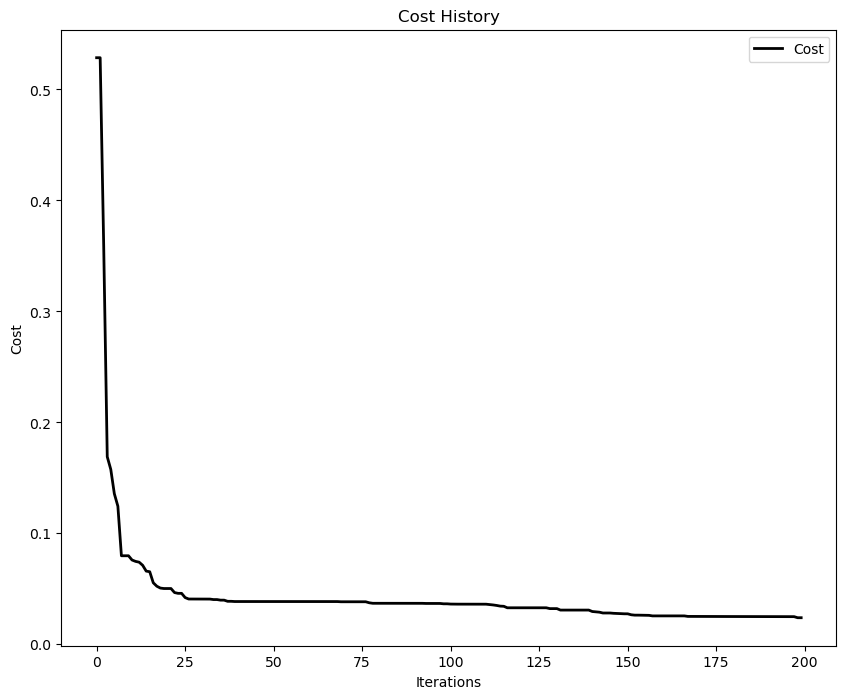

In [17]:
from pyswarms.utils.plotters import plot_cost_history

# Obtain cost history from optimizer instance
cost_history = optimizer.cost_history

# Plot!
plot_cost_history(cost_history)
plt.show()

## Plots

RMSE = 0.009280490933538355
R= 0.9762011323274737
bias = 0.0005127489543891666
KGE= 0.9759403119683356


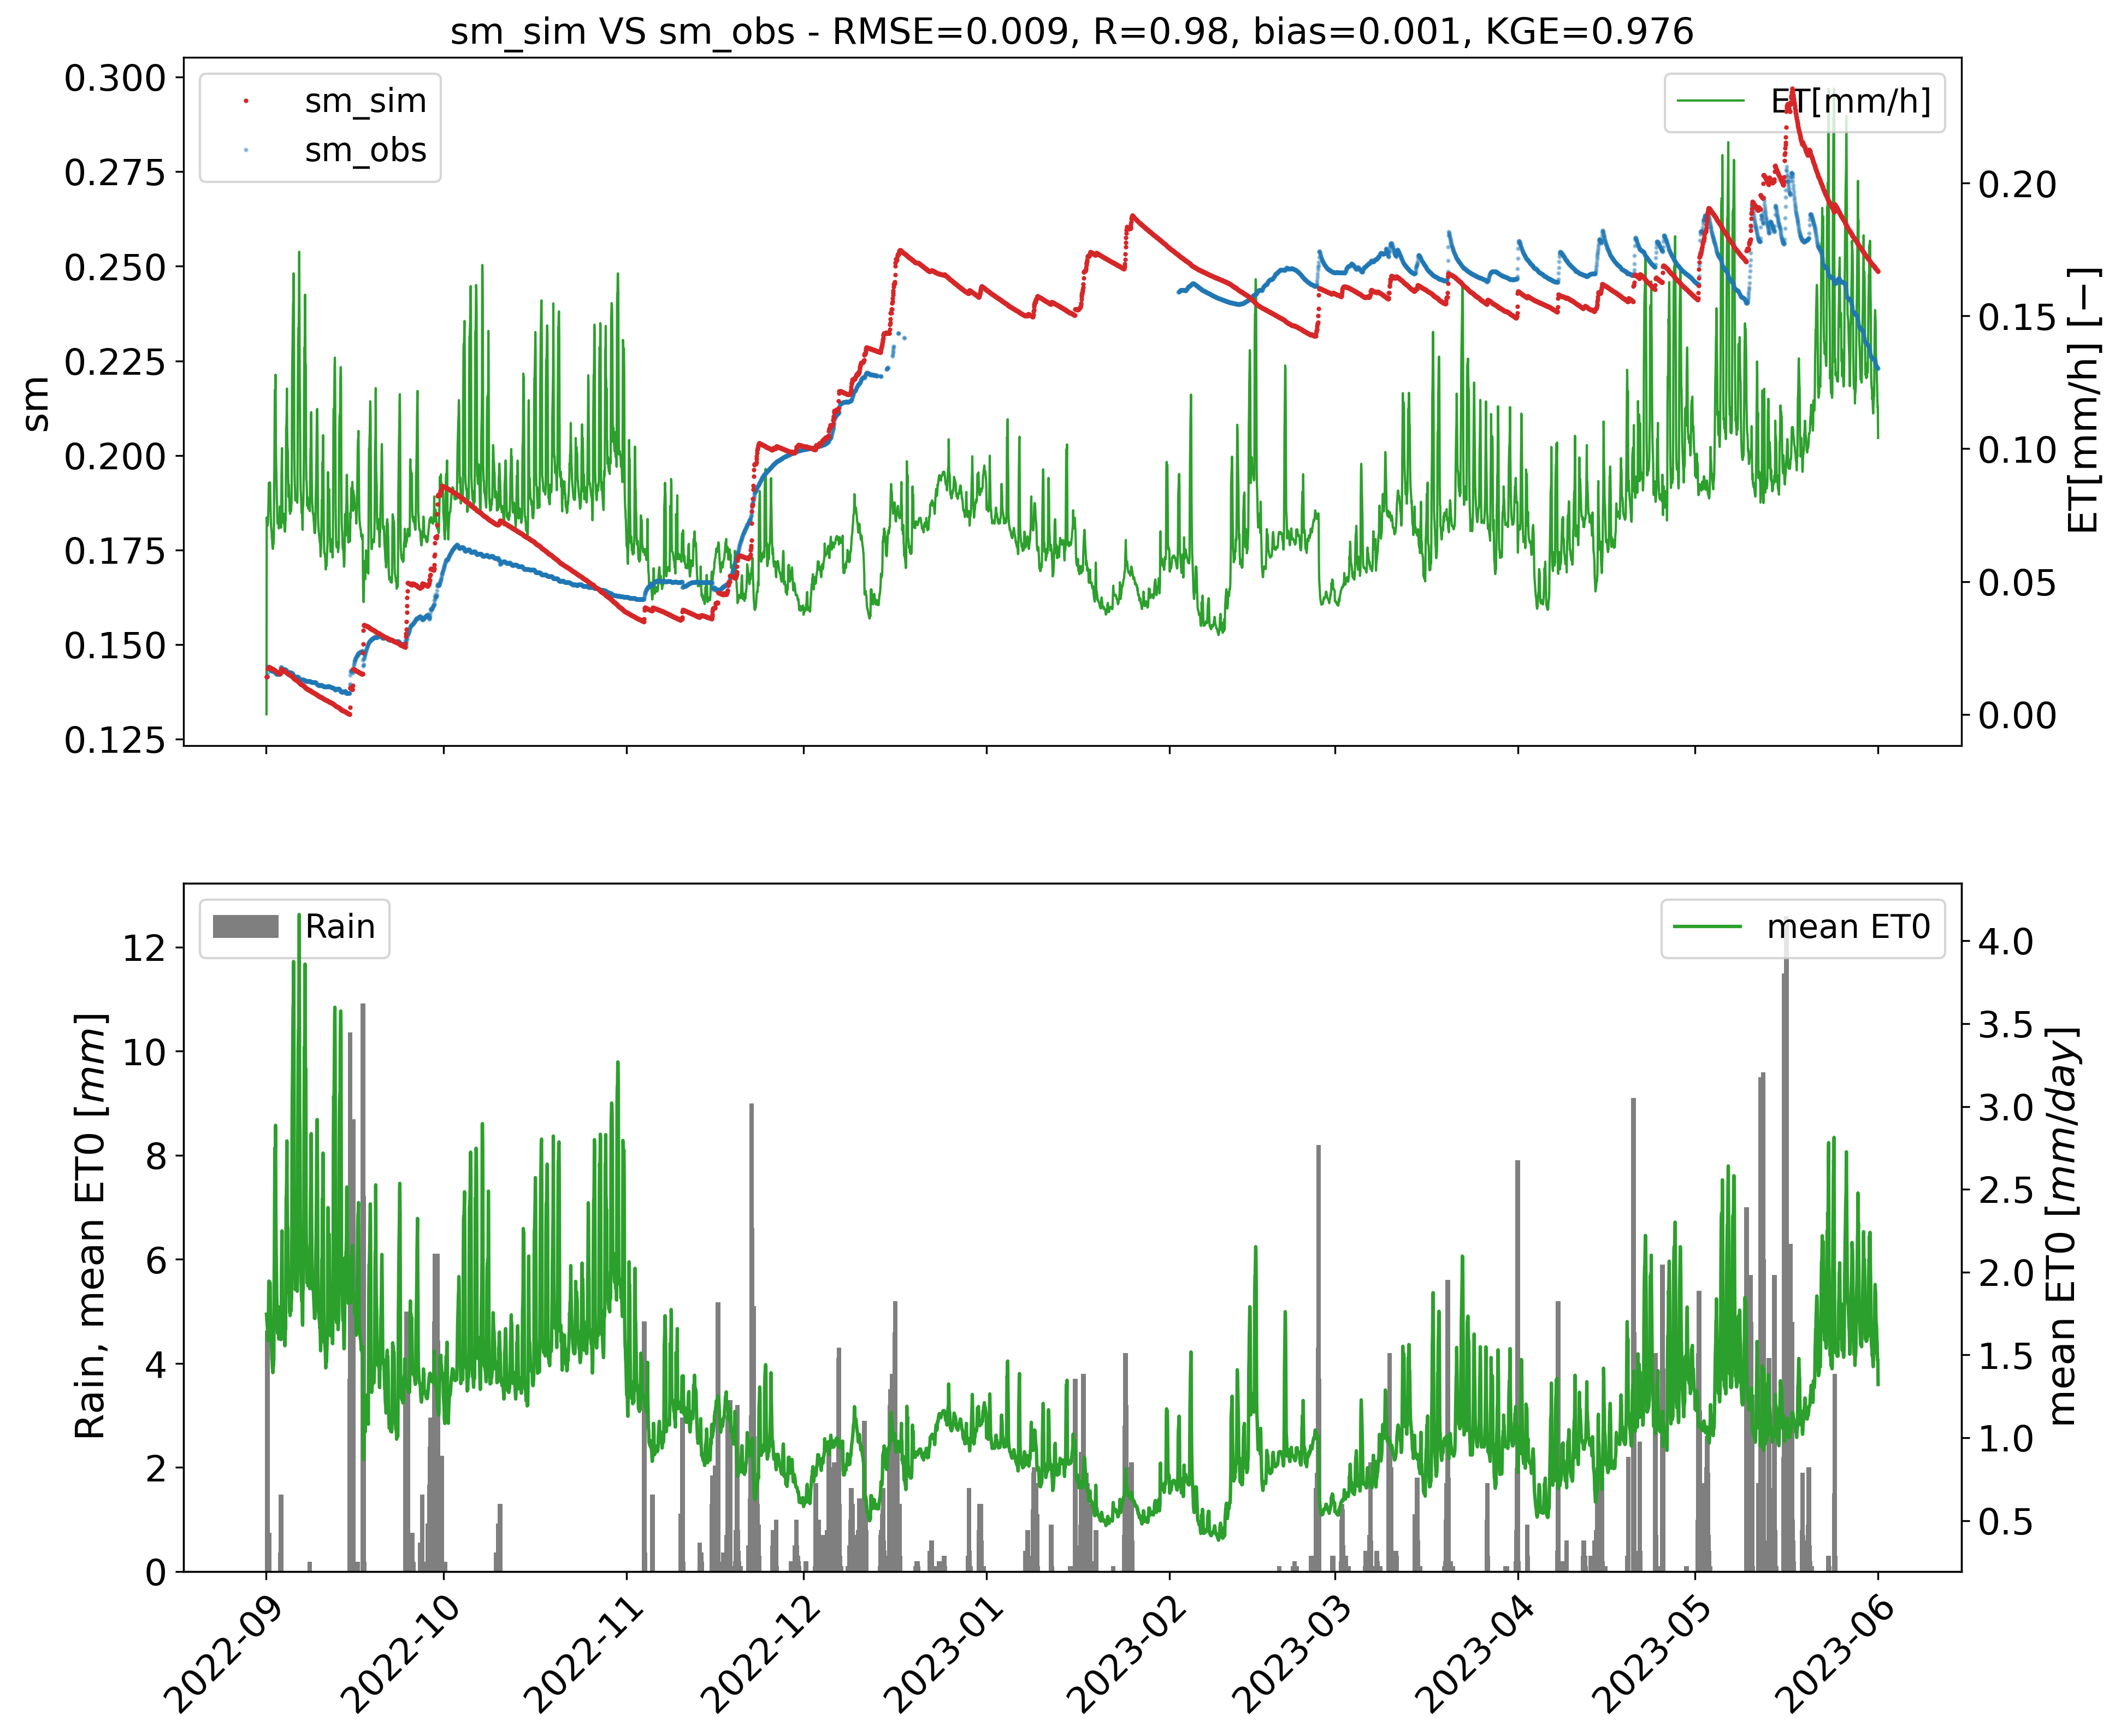

In [18]:
#####################################################################
# Double plot
#####################################################################
opt_show=True    
from scipy.signal import savgol_filter
        
if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(2, 1,constrained_layout=False,figsize=(14, 12), sharex=True,dpi=300,)


from scipy.signal import savgol_filter

plot_double(fig, ax,
            times1=t, data1=[sm35_ext, WW1], data1_label=r'sm', 
            input1=ET1, input1_label='ET[mm/h]',
            data1_mask=mask_gap_sm,
            times3=t, data3=[P, EPOT],
            data3_label=['Rain', 'mean ET0'],
            user_input=[''],
           )

for axi in ax:
    # axi.set_xlim(xmin=t[0], xmax=t[-1])
    axi.tick_params(axis='both', labelsize=16)
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    plt.savefig(folder_plot+filename+filename_triple+extension_plot)

if opt_show: plt.show()
plt.close()

In [20]:
if automate: opt_save=True
else: opt_save = True if input('Save csv with soil moisture values? [y/n]')=='y' else False

if opt_save:
    df = pd.DataFrame(timeseries(t,WW1), columns=['Date', 'simul_SM[m3m-3]']).set_index('Date')
    df.to_csv(folder_plot+filename+'_sm_sheet.csv')